# Fitting quasi-normal modes in A17A17q100d17p000

We begin with some standard imports and global settings.

## Preliminaries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# these are just some standard setup
# must edit to do GPU though - see tip below

# disable numpy multithreading to avoid conflicts (this is for jax on cpu I think)
# with jax multiprocessing in numpyro
import os
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np

# import jax and set it up to use double precision
from jax import config
config.update("jax_enable_x64", False)

# import numpyro and set it up to use 4 CPU devices
import numpyro
numpyro.set_host_device_count(4)
numpyro.set_platform('cpu')

# we will use matplotlib, arviz and seaborn for some of the plotting
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

# disable some warning shown by importing LALSuite from a notebook
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

# import ringdown package
import ringdown as rd

# set plotting context
sns.set_context('notebook')
sns.set_palette('colorblind')

From here on we might need to have a loop over each of the taper fcns

In [ ]:
import pandas as pd
from ringdown.data import Data

tapers = ['cosine', 'planck', 'hann']
wf = tapers[0] # we only do one taper fcn for now
# loop goes here

fit = rd.Fit(modes=[(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)])
fit.set_target(t0=0.5576171875, ra=1.375, dec=-1.2108, psi=1.5707963267948966, duration=0.9072265625)

df = pd.read_csv('injected_data.csv')
for ifo in ["H1", "L1"]:
    fit.data = {
        'H1': pd.Series(df[f'H1_{wf}'].values, index=df['time'].values),
        'L1': pd.Series(df[f'L1_{wf}'].values, index=df['time'].values)
    }
    # Create the Data object manually
    #d = Data(df["strain"].values, index=df["time"].values, ifo=ifo)
    # Add to the fit
    #fit.add_data(d)

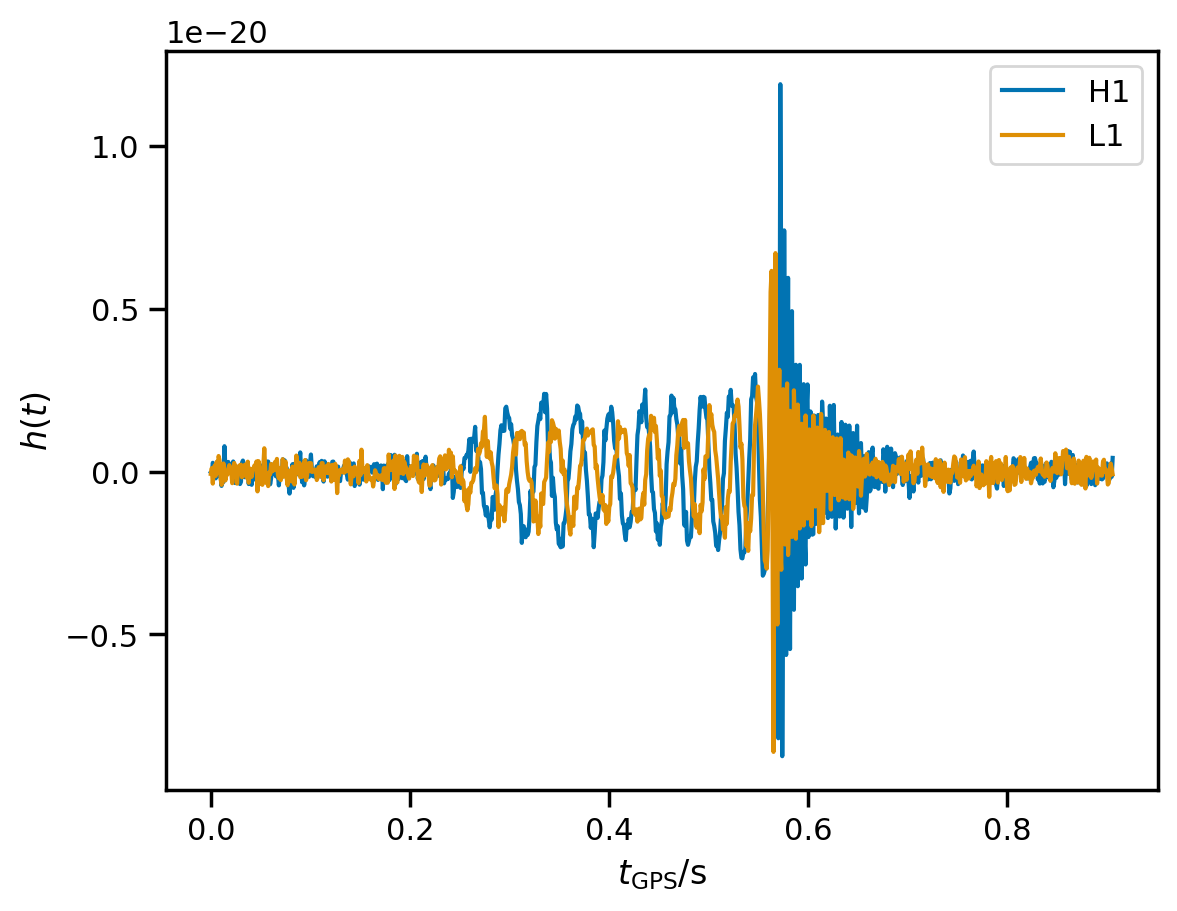

In [4]:
for ifo, data in fit.data.items():
    data[::4].plot(label=ifo)
plt.xlabel(r'$t_\mathrm{GPS} / \mathrm{s}$');
plt.ylabel(r'$h(t)$');
plt.legend(loc='best');

Here are estimated noise PSDs for our data:

In [5]:
#recall that ASD = sqrt(PSD) - we have already plotted ASD for our sim data, so should be able to compare later

for ifo, data in fit.data.items():
    plt.loglog(data.get_psd().iloc[1:], label=ifo)
plt.xlabel(r'$f / \mathrm{Hz}$');
plt.ylabel(r'$P\left( f \right) / \mathrm{Hz}^{-1}$');
plt.legend(loc='best');

AttributeError: 'Series' object has no attribute 'get_psd'

#### Data conditioning

We condition the data - downsample by factor of 8 and set the f_min

#TODO:
Come back and adjust f_min to be the f_1 from the tapering. Need to keep track of it in an object somehow

In [8]:
fit.condition_data(ds=8, f_min=20)

<div class="alert alert-info">

Warning

The conditioning function has a large number of options to manipulate the data in several ways. You should always make sure that the defaults make sense for your data!

</div>

We can visualize the segment of conditioned analysis data as another sanity check:

In [9]:
for i, d in fit.analysis_data.items():
    d.plot(label=i)
    plt.axvline(fit.start_times[i], ls='--', alpha=0.5, lw=3, c='gray')
plt.xlabel(r'$t_\mathrm{GPS} / \mathrm{s}$');
plt.ylabel(r'$h(t)$');
plt.legend(loc='best');

ValueError: H1 start time not in data

The wave arrived first at Livingston, then at Hanford, which is why the time segments are not exactly aligned.

#### Autocovariance function

A key ingredient in our likelihood calculation is the autocovariance function (ACF) of the noise, which is the time-domain equivalent of the power spectral density (PSD). You can load estimates of the ACF from disk, derive it from a PSD, or estimate it directly from the data. We do the latter below, with some default options.

In [ ]:
fit.compute_acfs(f_min=20)

We can use the ACFs to whiten the analysis data and plot it once again.

In [ ]:
wd = fit.whiten(fit.analysis_data)
for i, d in wd.items():
    d.plot(label=i)
plt.xlabel(r'$t_\mathrm{GPS} / \mathrm{s}$');
plt.ylabel(r'whitened $h(t)$');
plt.legend(loc='best');

The signal is visible towards the beginning of the whitened data.

### Run fit

We are almost ready to run the fit. Before sampling over the posterior on modes, we need to set up some priors with reasonable choices. We can see all the options available by using querying the `valid_model_settings` argument.

In [ ]:
print(fit.valid_model_settings)

These settings determine the prior and type of fit. For a vanilla Kerr fit with generic mode polarizations (not parametrized in terms of a source inclination), we only need to specify an amplitude scale, and a mass range.

In [ ]:
fit.update_model(a_scale_max=5e-20, m_min=40.0, m_max=140.0, cosi=-1)

We are finally ready to run! This should only take a couple of minutes on a modern desktop computer using CPUs.

In [ ]:
fit.run()

In [ ]:
fit.result

The result of our fit is held in `fit.result`. This is just an `arviz.InferenceData` object, with some additional ringdown-specific functionality. As such we can use all tools in ArViz easily.

In [ ]:
az.summary(fit.result, var_names=['a', 'm', 'chi', 'f', 'g'])

We can visualize the result of the fit using a trace plot. This allows us to visualize the chains and diagnose any potential divergences.

In [ ]:
az.plot_trace(fit.result, var_names=['m', 'chi', 'a']);

We can access the posterior samples directly in `fit.result.posterior`. We can also obtain a Pandas `DataFrame` with all chains stacked together. This can be really convenient for plotting and other manipulations.

In [ ]:
# draw 500 samples from the posterior
fit.result.get_parameter_dataframe(500, latex=True)

### Plot results

We can make some quick plots of the results using arviz and seaborn. Below we demonstrate a few possible ways of doing this.

#### Remnant mass and spin

In [ ]:
az.plot_pair(fit.result, var_names=['m', 'chi'], marginals=True,
             kind='kde', reference_values={'m': 70, 'chi': 0.7});

#### Mode amplitudes

In [ ]:
df = fit.result.get_parameter_dataframe()
g = sns.jointplot(x=df['a_220'], y=df['a_221'], kind='kde', fill=True);
g.ax_joint.set_xlabel('$A_{220}$');
g.ax_joint.set_ylabel('$A_{221}$');

#### Mode frequencies

In [ ]:
df = fit.result.get_mode_parameter_dataframe(500, latex=True)
key_map = fit.result.get_parameter_key_map(modes=False)

pg = sns.PairGrid(df, vars=[key_map[k] for k in ['f', 'g']],
                  diag_sharey=False, hue='mode')
pg.map_diag(sns.kdeplot);
pg.map_upper(sns.scatterplot);
pg.map_lower(rd.utils.kdeplot, levels=[0.9, 0.5, 0.1]);

#### Waveform reconstructions

Plot 90% credible interval for the reconstructions at each detector.

In [ ]:
fig, axs = plt.subplots(1, len(fit.ifos), figsize=(12, 4))
axs = np.atleast_1d(axs)
for mode in fit.result.modes:
    hdet_mode_cls = [fit.result.get_strain_quantile(q, mode=mode) for q in [0.5, 0.05, 0.95]]
    for i, ax in zip(fit.ifos, axs):
        m, l, h = [hcl[i] for hcl in hdet_mode_cls]
        ax.plot(m, label=mode.get_label())
        ax.fill_between(m.index, l, h, alpha=0.5)
    
hdet_cls = [fit.result.get_strain_quantile(q) for q in [0.5, 0.05, 0.95]]    
for i, ax in zip(fit.ifos, axs):
    m, l, h = [hcl[i] for hcl in hdet_cls]
        
    ax.plot(m, label='total')
    ax.fill_between(m.index, l, h, alpha=0.5)
    
    ax.set_xlim(fit.start_times[i]- 0.001,
                fit.start_times[i] + 0.025)
    ax.set_xlabel(r'$t_\mathrm{GPS} / \mathrm{s}$')
    ax.set_ylabel(f'$h(t)$ {i}');
    ax.legend();

#### Signal to noise ratio

In [ ]:
snrs = fit.result.compute_posterior_snrs(optimal=False, network=True)
sns.kdeplot(snrs);
plt.axvline(np.median(snrs), ls='--')
plt.xlabel('matched-filter network SNR');